In [1]:
# Data organization
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt 
import seaborn as sns

# Pre-processing, modeling and evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import TomekLinks
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Saving model data
import pickle as pkl 

In [2]:
df = pd.read_csv('training_data.csv')

In [3]:
columns = ['credit_given', 'gender', 'education', 'marital_status', 'age', 'sep_pay', 'aug_pay', 'jul_pay', 'jun_pay', 'may_pay', 'apr_pay', 'sep_bill', 'aug_bill', 'jul_bill', 'jun_bill', 'may_bill', 'apr_bill', 'sep_paid', 'aug_paid', 'jul_paid', 'jun_paid', 'may_paid', 'apr_paid', 'Y']

In [4]:
df.drop(columns = 'Unnamed: 0', inplace = True)
#double index
df.drop(18381, axis = 0, inplace = True)
#row with column names in it
df.drop(22464, axis = 0, inplace = True)
#I think this line is the sum of all columns
df.columns = columns

In [5]:
# Broadcast all columns into ints
df = df[['credit_given', 'gender', 'education', 'marital_status', 'age', 'sep_pay', 'aug_pay', 'jul_pay', 'jun_pay', 'may_pay', 'apr_pay', 'sep_bill', 'aug_bill', 'jul_bill', 'jun_bill', 'may_bill', 'apr_bill', 'sep_paid', 'aug_paid', 'jul_paid', 'jun_paid', 'may_paid', 'apr_paid', 'Y']].astype(int)

# Bin unlabeled categorical data
df.education = df.education.apply(lambda x: 4 if x > 3 or x == 0 else x)
df['gender'] = np.where(df.gender == 1, df.gender, 0)

In [6]:
df.apr_pay = df.apr_pay.apply(lambda x: 6 if x > 6 else x)
df.may_pay = df.may_pay.apply(lambda x: 6 if x > 6 else x)
df.jun_pay = df.jun_pay.apply(lambda x: 6 if x > 6 else x)
df.jul_pay = df.jul_pay.apply(lambda x: 6 if x > 6 else x)
df.aug_pay = df.aug_pay.apply(lambda x: 6 if x > 6 else x)
df.sep_pay = df.sep_pay.apply(lambda x: 6 if x > 6 else x)

df.apr_pay = df.apr_pay.apply(lambda x: 2 if x==1 else x)
df.may_pay = df.may_pay.apply(lambda x: 2 if x==1 else x)
df.jun_pay = df.jun_pay.apply(lambda x: 2 if x==1 else x)
df.jul_pay = df.jul_pay.apply(lambda x: 2 if x==1 else x)
df.aug_pay = df.aug_pay.apply(lambda x: 2 if x ==1 else x)
df.sep_pay = df.sep_pay.apply(lambda x: 2 if x ==1 else x)

In [7]:
df.apr_bill = df.apr_bill.apply(lambda x: 0 if x < 0 else x)
df.may_bill = df.may_bill.apply(lambda x: 0 if x < 0 else x)
df.jun_bill = df.jun_bill.apply(lambda x: 0 if x < 0 else x)
df.jul_bill = df.jul_bill.apply(lambda x: 0 if x < 0 else x)
df.aug_bill = df.aug_bill.apply(lambda x: 0 if x < 0 else x)
df.sep_bill = df.sep_bill.apply(lambda x: 0 if x < 0 else x)


#new in this iteration

In [8]:
df['avg_bill'] = df[['sep_bill', 'aug_bill', 'jul_bill', 'jun_bill', 'may_bill', 'apr_bill']].mean(axis = 1)
df['avg_paid'] = df[['sep_paid', 'aug_paid', 'jul_paid', 'jun_paid', 'may_paid', 'apr_paid']].mean(axis = 1)
df['avg_dif'] = df['avg_bill'] - df['avg_paid']

In [9]:
df_use = pd.DataFrame(columns = ['a'])

df_use['sep_use'] = df.sep_bill/df.credit_given
df_use['aug_use'] = df.aug_bill/df.credit_given
df_use['jul_use'] = df.jul_bill/df.credit_given
df_use['jun_use'] = df.jun_bill/df.credit_given
df_use['may_use'] = df.may_bill/df.credit_given
df_use['apr_use'] = df.apr_bill/df.credit_given
#added since last test
df_use['avg_use'] = df_use[['sep_use', 'aug_use', 'jul_use', 'jun_use', 'may_use', 'apr_use']].mean(axis = 1)


df_use.drop(columns = 'a', inplace = True)

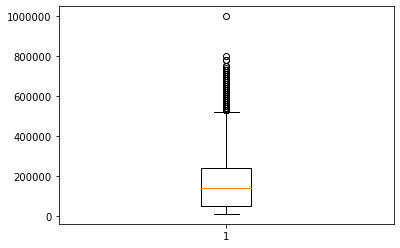

In [10]:
plt.boxplot(df.credit_given);

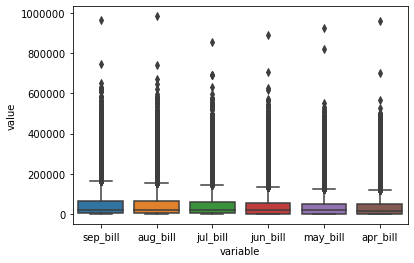

In [11]:
sns.boxplot(x = 'variable', y = 'value', data = pd.melt(df[['sep_bill', 'aug_bill', 'jul_bill', 'jun_bill', 'may_bill', 'apr_bill']]));

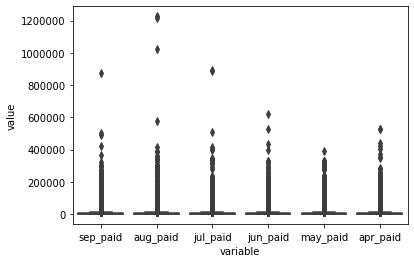

In [12]:
sns.boxplot(x = 'variable', y = 'value', data = pd.melt(df[['sep_paid', 'aug_paid', 'jul_paid', 'jun_paid', 'may_paid', 'apr_paid']]));

In [13]:
def dummy_list(column, prefix, drop_value):
    ''' Takes in a column, a prefix and drop value and generates a DataFrame of dummy columns with the specified prefix and column categories minus the specified drop value'''
    dum = pd.get_dummies(column, prefix = prefix)
    dum = dum.drop(columns = f'{prefix}_{drop_value}')
    return dum

def dummy_df(list_of_columns, list_of_prefixes, list_of_drop_values):
    r = pd.DataFrame(columns = ['a'])
    for i in range(0, len(list_of_columns)-1):
        r = pd.concat([r, dummy_list(list_of_columns[i], list_of_prefixes[i], list_of_drop_values[i])], axis = 1)
    return r

In [14]:
cols = [df.sep_pay, df.aug_pay, df.jul_pay, df.jun_pay, df.may_pay, df.apr_pay]

pref = ['sep', 'aug', 'jul', 'jun', 'may', 'apr']

drops = [6,6,6,6,6,6]
#tune this parameter, was 7 before capping
dum_df = dummy_df(cols, pref, drops)

dum_df.drop(columns = 'a', inplace = True)

mar_dum = dummy_list(df.marital_status, 'mar', 0)

ed_dum = dummy_list(df.education, 'ed', 4)

Y = df.Y

df.drop(columns = ['sep_pay', 'aug_pay', 'jul_pay', 'jun_pay', 'may_pay', 'apr_pay', 'marital_status', 'education', 'Y'], inplace = True)

In [15]:
X = pd.concat([df, dum_df, mar_dum, ed_dum], axis = 1)

X_train , X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=12, stratify = Y)

#random state was 12

In [16]:
scale = MinMaxScaler()

X_train1 = pd.DataFrame(scale.fit_transform(X_train))
X_test1 = pd.DataFrame(scale.transform(X_test))
X_train1.columns = X_train.columns
X_test1.columns = X_test.columns

In [17]:
# knn = KNeighborsClassifier(n_neighbors=15)
# knn.fit(X_train1, y_train)
# y_predknn = knn.predict(X_train1)
# y_predknn_test = knn.predict(X_test1)
# print(metrics.f1_score(y_train, y_predknn))
# print(metrics.f1_score(y_test, y_predknn_test))
# #4607 15 neighbors
# .4545 with negative bill vals removed

In [ ]:
logreg = LogisticRegression(penalty = 'l2', C=1, solver = 'liblinear')

lr = logreg.fit(X_train1, y_train)

y_pred = lr.predict(X_train1)
y_pred_test = lr.predict(X_test1)

print(metrics.f1_score(y_train, y_pred))
print(metrics.f1_score(y_test, y_pred_test))
#.4659 l2, c1, liblinear
#.4751 after random state update, same params
#.4757 after dropping outliers from apr_bill
#.4669 all neg bills rem

In [ ]:
logreg = LogisticRegression(penalty = 'l2', C= .05, solver = 'liblinear', class_weight = 'balanced')
lr = logreg.fit(X_train1, y_train)

y_pred = lr.predict(X_train1)
y_pred_test = lr.predict(X_test1)

print(metrics.f1_score(y_train, y_pred))
print(metrics.f1_score(y_test, y_pred_test))
print(metrics.accuracy_score(y_test, y_pred_test))

# .5488 l2, c .05, liblinear, balanced
# \/ .5378 after random state, same params
# .5376 after dropping apr bill outliers
#.5380 all neg bills removed

In [ ]:
from sklearn.feature_selection import RFECV
ols = LogisticRegression()

selector = RFECV(estimator=ols, step=2, cv=5, scoring='neg_mean_squared_error', verbose =2, n_jobs=-1)

selector.fit(X_train1, y_train)

In [ ]:
selected_columns = X_train1.columns[selector.support_]
removed_columns = X_train1.columns[~selector.support_]

In [ ]:
selected_columns

In [ ]:
logreg = LogisticRegression(penalty = 'l1', C= .05, solver = 'liblinear', class_weight = 'balanced')

lr = logreg.fit(X_train1[selected_columns], y_train)

y_pred = lr.predict(X_train1[selected_columns])
y_pred_test = lr.predict(X_test1[selected_columns])

print(metrics.f1_score(y_train, y_pred))
print(metrics.f1_score(y_test, y_pred_test))
print(metrics.accuracy_score(y_test, y_pred_test))

# .5469 l1 c .05, liblinear, balanced
# .5324 after random state update
# .5311 after removing outliers

In [ ]:
parameters = {'penalty' : ['l1', 'l2'], 'C': [.03, .035, .4, .45, .5]}

grid_tree = GridSearchCV(logreg, parameters, cv=10, scoring='f1', verbose=1, n_jobs=-1)

grid_tree.fit(X_train,y_train)

In [ ]:
print(grid_tree.best_score_)
print(grid_tree.best_params_)
print(grid_tree.best_estimator_)
#.5223 .035, l1, balanced, liblinear
#.5327 after random state update
#.5331 after removing apr outliers, l1, c = .4
#.5350 stratified on Y, rnd state update

In [ ]:
y_pred = grid_tree.best_estimator_.predict(X_test)
metrics.f1_score(y_test, y_pred)
#.5401 \/
#nominal diff with neg vals removed

In [ ]:
tree_clf = DecisionTreeClassifier(max_features=15, max_depth=7, random_state=42, criterion= 'entropy')
tree_clf.fit(X_train, y_train)

tree_pred = tree_clf.predict(X_train)
test_tree_pred = tree_clf.predict(X_test)

In [ ]:
print(metrics.f1_score(y_train, tree_pred))
print(metrics.f1_score(y_test, test_tree_pred))

In [ ]:
parameters = {'min_samples_leaf': range(60, 105), 'max_depth': range(5,9), 'class_weight' : ['balanced', None]}

grid_tree = GridSearchCV(tree_clf, parameters, cv=10, scoring='f1', verbose=1, n_jobs=-1)

grid_tree.fit(X_train,y_train)

In [ ]:
print(grid_tree.best_score_)
print(grid_tree.best_params_)
print(grid_tree.best_estimator_)
#.5180 balanced, md 7, min sam 72 

In [ ]:
y_pred = grid_tree.best_estimator_.predict(X_test)
metrics.f1_score(y_test, y_pred)

In [ ]:
#this model needs tuning - could be the best outcome if the overfit can be corrected
sm = SMOTE(random_state=2, k_neighbors=55, n_jobs=-1)
X_trainsm, y_trainsm = sm.fit_sample(X_train1, y_train)

smlr = LogisticRegression(solver = 'liblinear', penalty='l2', C= .035)

smlr.fit(X_trainsm, y_trainsm)

y_sm_pred = smlr.predict(X_trainsm)
y_smtest_pred = smlr.predict(X_test1)

print(metrics.f1_score(y_trainsm, y_sm_pred))
print(metrics.f1_score(y_test, y_smtest_pred))

# .5500
#.5360 after rnd state, outliers

In [ ]:
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train1, y_train)

y_res.value_counts()

tl = TomekLinks()
X_resampled, y_resampled = tl.fit_sample(X_train1, y_train)

In [ ]:
tomek_lr = LogisticRegression(solver='liblinear')

tomek_lr.fit(X_resampled, y_resampled)

tomek_pred = tomek_lr.predict(X_resampled)
tomek_test_pred = tomek_lr.predict(X_test1)

print(metrics.f1_score(y_resampled, tomek_pred))
print(metrics.f1_score(y_test, tomek_test_pred))
print(metrics.accuracy_score(y_resampled, tomek_pred))
#.5024

In [ ]:
voting_clf = VotingClassifier(
                estimators=[('logreg', lr), ('SMOTE', smlr), ('decisiontree', tree_clf)], 
                voting='hard')

voting_clf.fit(X_train1, y_train)

vc_preds = voting_clf.predict(X_test1)

print(metrics.f1_score(y_test, vc_preds))
#.5077

In [ ]:
#tune hyperparameters- this model may be the best
bc_lr = BaggingClassifier(
            base_estimator=LogisticRegression(penalty = 'l2', C= .05,                   solver = 'liblinear', class_weight = 'balanced'), n_estimators=             500, oob_score= True)

# max_samples= 0.8,
#             max_features= 15,

bc_lr.fit(X_train1, y_train)

bc_lr.oob_score_

In [ ]:
bc_lr_trainpreds = bc_lr.predict(X_train1)
bc_lr_preds = bc_lr.predict(X_test1)

bc_lrtrain_f1 = metrics.f1_score(y_train, bc_lr_trainpreds)
bc_lr_f1 = metrics.f1_score(y_test, bc_lr_preds)

print(bc_lrtrain_f1)
print(bc_lr_f1)
#.5430
#.5309 after neg values removed
#.5283 6s
#.5318 l2, c.05, liblinear, balanced

In [ ]:
#reduce features here

bc_smlr = BaggingClassifier(base_estimator=LogisticRegression(class_weight='balanced', solver='liblinear', C= .035, penalty='l1'), n_estimators=500, oob_score=True, max_features=20, max_samples=.7)

bc_smlr.fit(X_trainsm, y_trainsm)

bcsm_pred = bc_smlr.predict(X_trainsm)

bcsm_test_pred = bc_smlr.predict(X_test1)

print(metrics.f1_score(y_trainsm, bcsm_pred))
print(metrics.f1_score(y_test, bcsm_test_pred))

In [18]:
#gridsearch here as well
rfc = RandomForestClassifier(random_state = 1, n_estimators=550, max_depth=6, bootstrap = True, oob_score = True, class_weight = 'balanced', max_features=11, verbose= 1, n_jobs=-1)

rfc.fit(X_train, y_train)

rfc_preds = rfc.predict(X_test)
rfc_trainpreds = rfc.predict(X_train)

rfc_f1 = metrics.f1_score(y_test, rfc_preds)
#.5560 rnd =1 n_est = 1000, max_d 4, bootstrap, oob_score, balanced, max ft 15

#.5524 (random_state = 1, n_estimators=300, max_depth=6, bootstrap = True, oob_score = True, class_weight = 'balanced', max_features=11, verbose= 1, n_jobs=-1)

#.5395 n_est 550, md 6, mx ft 11

#.5431 y stratified, dropped neg values new rnd state, 55, 6, 11

#.5398 with 0s as pay drop values

#.5405 with 6s

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 550 out of 550 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 550 out of 550 | elapsed:    0.2s finis

In [19]:
print('Test F1 score: ', rfc_f1)
print(metrics.f1_score(y_train, rfc_trainpreds))
rfc.oob_score_

Test F1 score:  0.5314643602743812
0.5692287950725009


0.772987045974092

In [ ]:
rfc_grid = RandomForestClassifier(random_state=1)

forest_params = {'max_depth':[8,9,10], 'max_features': [8,9,10], 'n_estimators':[550], 'class_weight' : ['balanced'], 'bootstrap' : [True], 'oob_score': [True]}

forest_grid = GridSearchCV(rfc_grid, forest_params, cv=10, scoring = 'f1',verbose= 2, n_jobs=-1)

forest_grid.fit(X_train,y_train)

In [ ]:
print(forest_grid.best_score_)
print(forest_grid.best_params_)
print(forest_grid.best_estimator_)

gridF_preds = forest_grid.predict(X_train)
gridF_testpreds = forest_grid.predict(X_test)

print(metrics.f1_score(y_train, gridF_preds))
print(metrics.f1_score(y_test, gridF_testpreds))

In [ ]:
# forest = RandomForestClassifier(random_state=1)

# gridF = GridSearchCV(forest, forest_params, cv = 10, verbose = 1, 
#                       n_jobs = -1)

# bestF = gridF.fit(X_train, y_train)

In [ ]:
# print(gridF.best_score_)
# print(gridF.best_params_)
# print(gridF.best_estimator_)

In [ ]:
gridF_preds = gridF.predict(X_train)
gridF_testpreds = gridF.predict(X_test)

print(metrics.f1_score(y_train, gridF_preds))
print(metrics.f1_score(y_test, gridF_testpreds))

In [ ]:
voting_clf = VotingClassifier(
                estimators=[('logreg', lr),('SMOTE', smlr), ('random      forest', rfc), ('xgb', xgb_optimized), ('bagged', bc_lr)], voting='hard')
voting_clf.fit(X_train1, y_train)
#55209 -knn

In [ ]:
vc_train_preds = voting_clf.predict(X_train1)
vc_test_preds = voting_clf.predict(X_test1)

print(metrics.f1_score(y_train, vc_train_preds))
print(metrics.f1_score(y_test, vc_test_preds))

In [ ]:
xbclf = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'logloss', max_depth = 3, min_child_weight= 3, learning_rate = .1, n_estimators = 300, verbosity = 1, n_jobs = -1, random_state=22)
xbclf.fit(X_train, y_train)

xgb_trainpred = xbclf.predict(X_train)
xgb_testpred = xbclf.predict(X_test)

In [ ]:
print(metrics.f1_score(y_train, xgb_trainpred))
print(metrics.f1_score(y_test, xgb_testpred))

In [ ]:
xgbgrid = xgb.XGBClassifier(random_state=22)

xgbgrid_params = {'objective' : ['binary:logistic'], 'eval_metric' : ['logloss'], 'max_depth':[3,4], 'min_child_weight': [2], 'eta': [.01, .05, .1, .2], 'n_estimators':[550], 'learning_rate':[.1], 'verbosity':[1], 'n_jobs': [-1]}

xgb_optimized = GridSearchCV(xgbgrid, xgbgrid_params, cv=10, scoring = 'f1', verbose= True, n_jobs=-1)

xgb_optimized.fit(X_train,y_train)

In [ ]:
xgb_optpred = xgb_optimized.predict(X_train)
xgb_opttestpred = xgb_optimized.predict(X_test)

print(xgb_optimized.best_score_)
print(xgb_optimized.best_params_)
print(xgb_optimized.best_estimator_)

print(metrics.f1_score(y_train, xgb_optpred))
print(metrics.f1_score(y_test, xgb_opttestpred))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

# define the keras model
model = Sequential()
model.add(Dense(100, input_dim=63, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train1, y_train, epochs=17, batch_size=10)

In [ ]:
keras_pred = model.predict(X_train1)
keras_test_pred = model.predict(X_test1)

print(model.evaluate(X_train1, y_train))
print(model.evaluate(X_test1, y_test))

# _, accuracy = model.evaluate(X_train, y_train)
# print('Accuracy: %.2f' % (accuracy*100))

In [ ]:
p = []
for i in keras_pred:
    if i < .5:
        p.append(0)
    else:
        p.append(1)

q = []
for i in keras_test_pred:
    if i < .5:
        q.append(0)
    else:
        q.append(1)

print(metrics.f1_score(y_train, p))
print(metrics.f1_score(y_test, q))

In [ ]:
q

In [ ]:
model_pickle_path = 'bakeoff_model.pkl'

# Create an variable to pickle and open it in write mode
model_pickle = open(model_pickle_path, 'wb')
pkl.dump(rfc, model_pickle)
model_pickle.close()